In [294]:
import tweepy
import pandas as pd
import re
import numpy as np
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [65]:
log = pd.read_csv("Login.txt")

In [119]:
consumerKey = log.Logs[0]
consumerSecret = log.Logs[1]
accessToken = log.Logs[2]
accessTokenSecret = log.Logs[3]

In [120]:
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)
authenticate.set_access_token(accessToken, accessTokenSecret)

In [121]:
api = tweepy.API(authenticate,wait_on_rate_limit=True)

In [143]:
def creating_df_of_tweets(tweets):
    df = pd.DataFrame([tweet.text for tweet in tweets], columns=["Tweets"])
    return df

In [162]:
def extracting_and_loading_tweets(tweeter_query, amnt):
    if amnt < 100:
        tweets = api.search(q=tweeter_query, lang="en", count=amnt)
        df = creating_df_of_tweets(tweets)
        return df
    else:
        left = (amnt - (100*(amnt//100)))
        my_tweet_list = []
        
        for page in tweepy.Cursor(api.search, q=tweeter_query,lang="en",
                          count=200).pages(amnt//100):
            my_tweet_list.extend(page)
        
        df = creating_df_of_tweets(my_tweet_list)
        
        if left != 0:
            left_tweets = api.search(q="Meta Facebook", lang="en", count=left)
            dfs = creating_df_of_tweets(left_tweets)
            df = pd.concat([dfs, df])
        
        return df
        
        

In [168]:
df = extracting_and_loading_tweets("Meta Facebook", 6000)

In [259]:
# Checking the unique values
len(set(df["Tweets"]))

3191

In [282]:
lst_unique = set(df["Tweets"])
df_test = pd.DataFrame(data=lst_unique, columns=["Tweets"])

In [283]:
len(df_test["Tweets"]) == len(set(df["Tweets"]))

True

In [284]:
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", '', text)
    text = re.sub(r"#", '', text)
    text = re.sub(r"RT[\s]+", "", text)
    text = re.sub(r"https?:\/\/\s+", '', text)  
    text = re.sub(r"(?:^|\W)crypto(?:$|\W)", '', text)
    text = re.sub(r"(?:^|\W)nft(?:$|\W)", '', text)
    text = re.sub(r"(?:^|\W)meta(?:$|\W)", '', text)
    text = re.sub(r"(?:^|\W)https(?:$|\W)", '', text)
    text = re.sub(r"(?:^|\W)t co(?:$|\W)", '', text)
    text = re.sub(r"(?:^|\W)facebook(?:$|\W)", '', text)
    return text

In [285]:
def more_cleaning(tweet, lst_of_words):
    for word in lst_of_words:
        if word in tweet:
            tweet = tweet.replace(word, "")
    return tweet
    

In [295]:
def remove_stopwords(tweet):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(tweet)
    filtered_tokens = []
    
    for word in word_tokens:
        if word.lower() not in stop_words:
            filtered_tokens.append(word)
            
    return " ".join(filtered_tokens)
    

In [296]:
len(df_test)

3191

In [287]:
df_test["Tweets"] = df_test["Tweets"].apply(clean_text)
df_test["Tweets"]

0       The Federal Trade Commission just got permissi...
1       : Hi  you have disabled my personal account (a...
2        \nMY FACEBOOK IS LOCKED FROM 15 JAN 2022. PLE...
3       Only 7,000 cheetahs left in the wild, and over...
4       Why The Microsoft-Activision Deal Is Good For ...
                              ...                        
3186    As with Facebook and Instagram, Meta regularly...
3187    : Up to 44 million UK Facebook users could sha...
3188       So, the guy mocked regularly at  (née for b...
3189     \n\n\n\n\n\n\nAfter a long time my fb page is...
3190    Only 7,000 cheetahs left in the wild, and over...
Name: Tweets, Length: 3191, dtype: object

In [300]:
df_test["Tweets"] = df_test["Tweets"].apply(lambda x: more_cleaning(x, ["Facebook", "meta", "Meta", "metaverse", "coin"]))
df_test["Tweets"] = df_test["Tweets"].apply(remove_stopwords)


In [298]:
df_test

,Tweets,Subjectivity,Polarity
0,Federal Trade Commission got permission file a...,0.800000,-0.600000
1,: Hi disabled personal account ( account name ...,0.300000,-0.100000
2,FACEBOOK LOCKED 15 JAN 2022 . PLEASE HELP RECO...,0.000000,0.000000
3,"7,000 cheetahs left wild , 4,000 sold ! become...",0.466667,0.041667
4,Microsoft-Activision Deal Good Mark Zuckerberg...,0.600000,0.700000
...,...,...,...
3186,"Instagram , regularly enriches WhatsApp new fe...",0.246503,0.068182
3187,: 44 million UK users could share £2.3bn damag...,0.000000,0.000000
3188,", guy mocked regularly ( née bully , was…//t.c...",0.076923,0.000000
3189,long time fb page monetize help,0.400000,-0.050000


In [289]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getAPolarity(text):
    return TextBlob(text).sentiment.polarity

In [290]:
df_test["Subjectivity"] = df_test["Tweets"].apply(getSubjectivity)
df_test["Polarity"] = df_test["Tweets"].apply(getPolarity)

In [291]:
df_test.head()

,Tweets,Subjectivity,Polarity
0,The Federal Trade Commission just got permissi...,0.800000,-0.600000
1,: Hi you have disabled my personal account (a...,0.300000,-0.100000
2,\nMY FACEBOOK IS LOCKED FROM 15 JAN 2022. PLE...,0.000000,0.000000
3,"Only 7,000 cheetahs left in the wild, and over...",0.466667,0.041667
4,Why The Microsoft-Activision Deal Is Good For ...,0.600000,0.700000


In [292]:
def create_wordscloud(tweets, title):
    plt.title(title)
    allWords = " ".join([twt for twt in tweets])
    wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(allWords)

    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


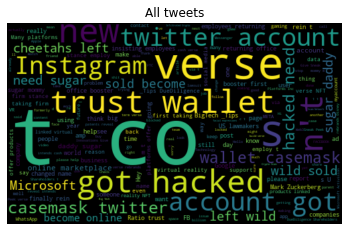

In [301]:
create_wordscloud(df_test["Tweets"], "All tweets")

In [255]:
df_test

,Tweets,Subjectivity,Polarity
0,The Federal Trade Commission just got permissi...,0.800000,-0.600000
1,: Hi you have disabled my personal account (a...,0.300000,-0.100000
2,\nMY FACEBOOK IS LOCKED FROM 15 JAN 2022. PLE...,0.000000,0.000000
3,"Only 7,000 cheetahs left in the wild, and over...",0.466667,0.041667
4,Why The Microsoft-Activision Deal Is Good For ...,0.600000,0.700000
...,...,...,...
3186,"As with and Instagram, Meta regularly enriche...",0.246503,0.068182
3187,: Up to 44 million UK users could share £2.3b...,0.000000,0.000000
3188,"So, the guy mocked regularly at (née for b...",0.076923,0.000000
3189,\n\n\n\n\n\n\nAfter a long time my fb page is...,0.400000,-0.050000


In [303]:
def tweetPositivity(score):
    if score > 0:
        return "Positive"
    if score == 0:
        return "Neutral"
    if score < 0:
        return "Negative"

In [304]:
df_test["Analysis"] = df_test["Polarity"].apply(tweetPositivity)

In [305]:
df_test[df_test["Analysis"] == "Negative"]

,Tweets,Subjectivity,Polarity,Analysis
0,Federal Trade Commission got permission file a...,0.800000,-0.600000,Negative
1,: Hi disabled personal account ( account name ...,0.300000,-0.100000,Negative
8,random Twitter spaces pass time somewhere some...,0.283333,-0.233333,Negative
32,": Every major brand , celebrity public figure ...",0.260417,-0.040625,Negative
61,: Whybsomeuser hasbeen disabled account last d...,0.183333,-0.100000,Negative
...,...,...,...,...
3168,fact people properly conceiving MMO accurate t...,0.577778,-0.200000,Negative
3171,owns yet worst messaging app planet .,1.000000,-1.000000,Negative
3173,unbelievable,1.000000,-0.250000,Negative
3183,`` serious taking action . 's message Mark Zuc...,0.383333,-0.116667,Negative


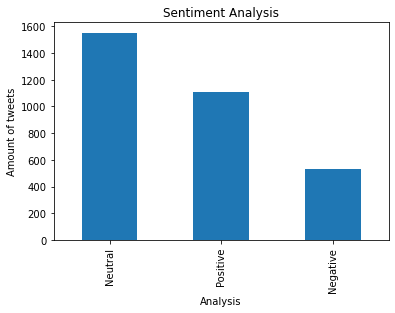

In [306]:
plt.title("Sentiment Analysis")
plt.xlabel("Analysis")
plt.ylabel("Amount of tweets")
df_test["Analysis"].value_counts().plot(kind="bar")
plt.show()

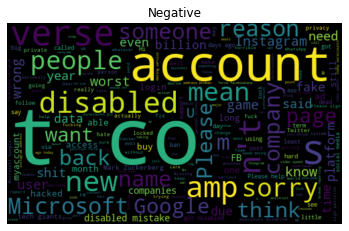

In [307]:
create_wordscloud(df_test[df_test["Analysis"] == "Negative"]["Tweets"], "Negative")